In [1]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [4]:
agg_strats = ['max','min']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [5]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [6]:
val_idx = X_train_agg['date_forecast'].between('2020-05-01', '2020-07-01')-1
ps = PredefinedSplit(test_fold=val_idx)

In [7]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

mod = XGBRegressor(
    # reg_lambda=10,
    reg_alpha=10,
    learning_rate=0.5,
    max_depth=5,
    n_estimators=50,
)

open('status.csv', 'w').close()
# build the pipeline
mod_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', mod)
])

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'max_ceiling_height_agl:m', 'max_cloud_base_agl:m', 'max_snow_density:kgm3', 'max_effective_cloud_cover_5h_mean', 'max_GHI_lag_-1h', 'max_GHI_lag_1h', 'max_temp*GHI_lag_-1h', 'max_temp*GHI_lag_1h', 'min_ceiling_height_agl:m', 'min_cloud_base_agl:m', 'min_snow_density:kgm3', 'min_effective_cloud_cover_5h_mean', 'min_GHI_lag_-1h', 'min_GHI_lag_1h', 'min_temp*GHI_lag_-1h', 'min_temp*GHI_lag_1h']


In [8]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}

In [9]:
# run grid search
# gs = GridSearchCV(
#     mod_pipe,
#     param_grid={
#         # 'estimator__learning_rate': np.arange(0.3, 0.025, -0.025),
#         'estimator__max_depth': np.arange(13, 1, -1)
#         # 'estimator__n_estimators': np.arange(150,0,-10),
#         # 'estimator__colsample_bytree': np.arange(0.5,1.0001,0.025),
#         # 'estimator__reg_alpha': np.arange(0, 20, 1)
#         # 'estimator__reg_lambda': np.arange(0, 30, 1),
#         # 'estimator__min_child_weight': np.arange(0,10,0.1)
#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring=scoring,
#     verbose=2,
#     refit='MAE'
# )

bs = BayesSearchCV(
    mod_pipe,
    search_spaces={
        'estimator__learning_rate': Real(0.05, 0.3),
        'estimator__max_depth': Integer(3, 13),
        'estimator__n_estimators': Integer(20,500),
        'estimator__colsample_bytree': Real(0.001,1),
        'estimator__reg_alpha': Real(0, 50),
        'estimator__reg_lambda': Real(0, 50),
        'estimator__min_child_weight': Real(0,50)
    },
    cv=ps,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_iter=150,
    n_points=6,
    return_train_score=True
)

bs.fit(X_train_agg, y_train_agg)


Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] END estimator__colsample_bytree=0.37493471866097433, estimator__learning_rate=0.1297995758596396, estimator__max_depth=8, estimator__min_child_weight=30.93173625701329, estimator__n_estimators=244, estimator__reg_alpha=30.95333041997867, estimator__reg_lambda=35.98603935159029; total time=   1.6s
[CV] END estimator__colsample_bytree=0.12020876815056018, estimator__learning_rate=0.16652728320056281, estimator__max_depth=12, estimator__min_child_weight=6.391896091570983, estimator__n_estimators=263, estimator__reg_alpha=30.463697007009895, estimator__reg_lambda=16.912161737700107; total time=   1.6s
[CV] END estimator__colsample_bytree=0.28044993901299164, estimator__learning_rate=0.28347950717128395, estimator__max_depth=5, estimator__min_child_weight=45.787268295972005, estimator__n_estimators=432, estimator__reg_alpha=27.007510078381703, estimator__reg_lambda=49.189661857249256; total time=   1.8s
[CV] END estimator__cols

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
              estimator=Pipeline(steps=[('columnTransformer',
                                         ColumnTransformer(n_jobs=-1,
                                                           remainder='passthrough',
                                                           transformers=[('imputer',
                                                                          SimpleImputer(strategy='constant'),
                                                                          ['delta_forecast',
                                                                           'max_ceiling_height_agl:m',
                                                                           'max_cloud_base_agl:m',
                                                                           'max_snow_density:kgm3',
                                                                           'max_effective_cloud_cover_5h_...
                             'estimator__min_child_weight': Real(low=0, high=50, prior='uniform', transform='normalize'),
                             'estimator__n_estimators': Integer(low=20, high=500, prior='uniform', transform='normalize'),
                             'estimator__reg_alpha': Real(low=0, high=50, prior='uniform', transform='normalize'),
                             'estimator__reg_lambda': Real(low=0, high=50, prior='uniform', transform='normalize')},
              verbose=2)

In [10]:
bs.best_params_

OrderedDict([('estimator__colsample_bytree', 1.0),
             ('estimator__learning_rate', 0.05110212345372205),
             ('estimator__max_depth', 9),
             ('estimator__min_child_weight', 43.21300667393793),
             ('estimator__n_estimators', 162),
             ('estimator__reg_alpha', 0.0),
             ('estimator__reg_lambda', 50.0)])

In [11]:
model = bs.best_estimator_

In [12]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

In [13]:
for key, values in gs.param_grid.items():
    pass

plt.figure(figsize=(20, 5))

sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

plt.figure(figsize=(20, 5))
sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

NameError: name 'gs' is not defined

In [ ]:
gs

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'max_ceiling_height_agl:m',
                                                                          'max_cloud_base_agl:m',
                                                                          'max_snow_density:kgm3',
                                                                          'max_effective_cloud_cover_5h_m...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=50,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'estimator__max_depth': array([13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2])},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [15]:
pred = pd.Series(model.predict(X_test_agg))

In [16]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 146.47338206151642


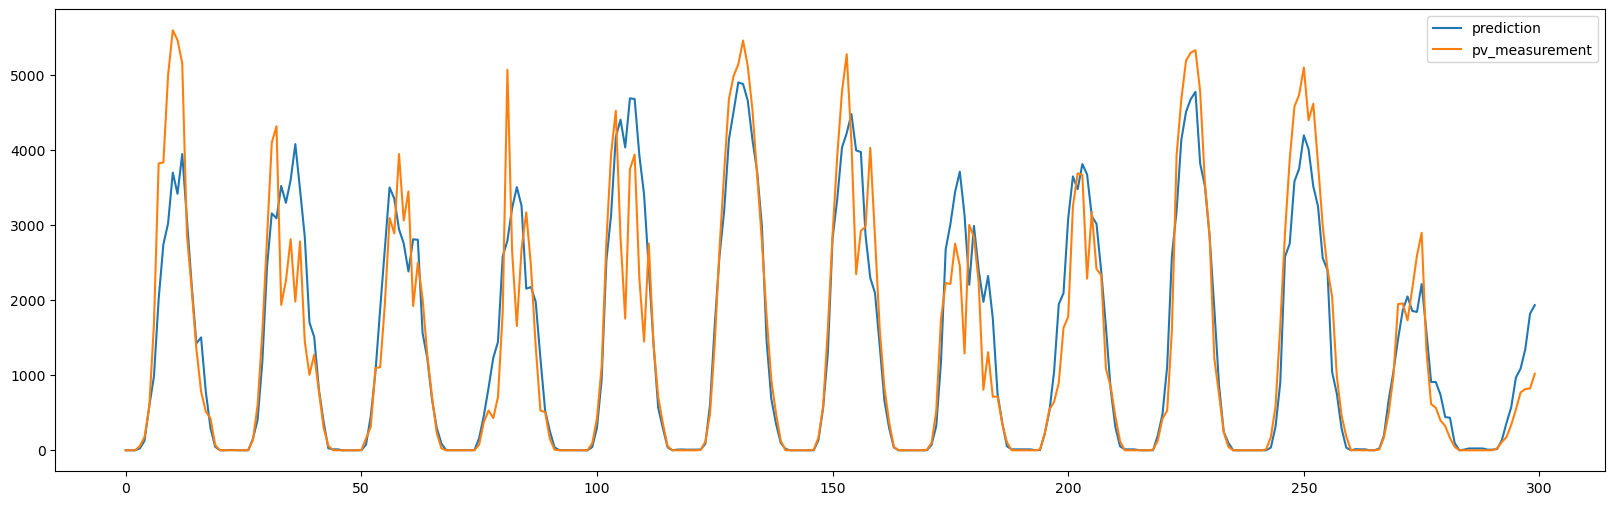

In [ ]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=0,end_idx=300)

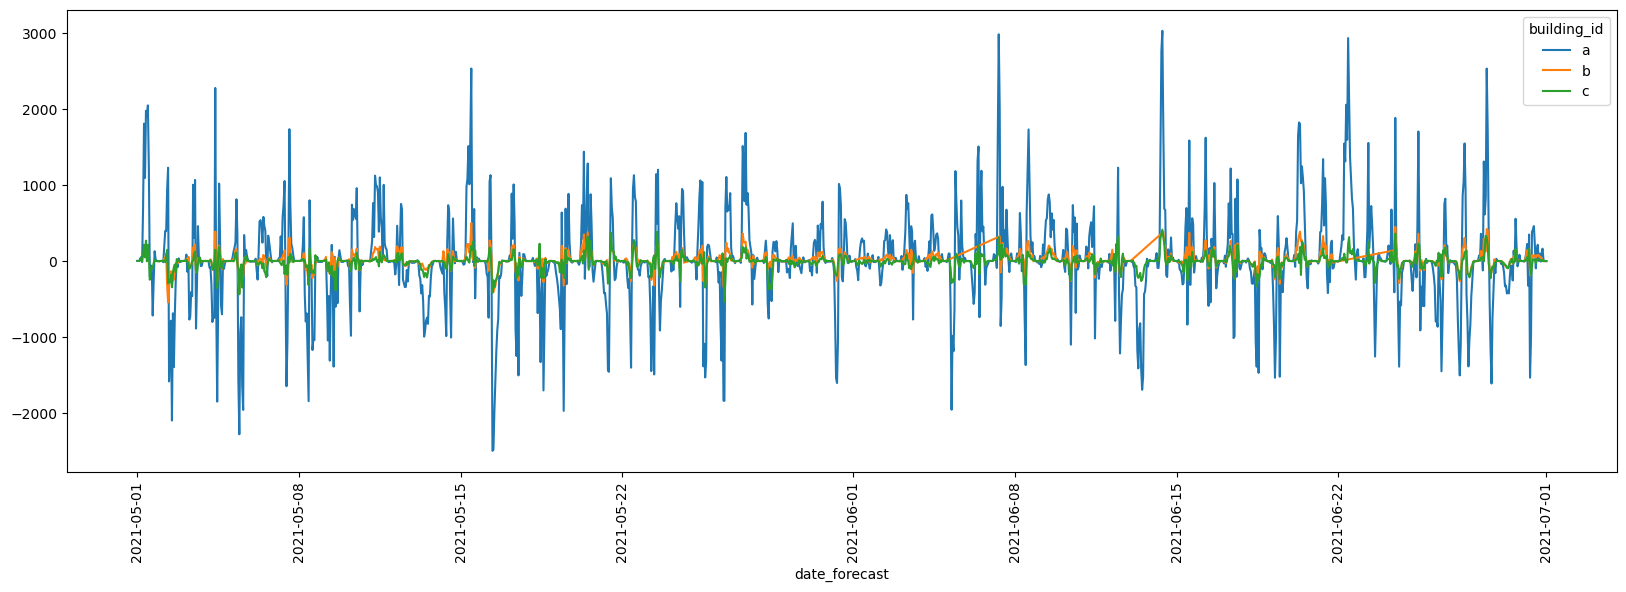

In [ ]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [17]:
model

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_l...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05110212345372205, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=43.21300667393793, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=162, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [19]:
X_all, y_all = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_all = X_all.select_dtypes(exclude=['datetime','timedelta','period[M]'])

model.fit(X_all, y_all)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_l...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05110212345372205, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=43.21300667393793, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=162, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [22]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='xgboost_min_max.csv',sun_el_thr=1)

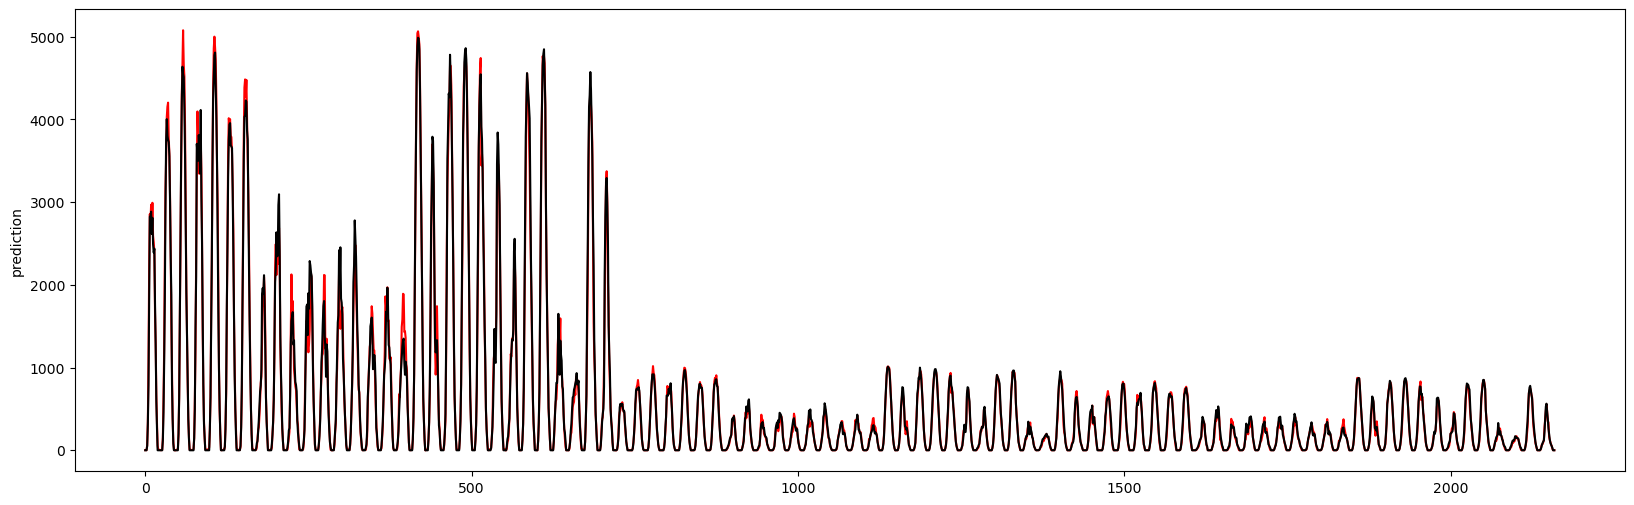

In [23]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')